In [364]:
import glob    #fileの名前の取得に必要
import numpy as np
import re

#https://qiita.com/neet-AI/items/2b3d7f743e4d6c6d8e10
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import random_rotation, random_shift, random_zoom
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import pandas as pd
from datetime import date
from datetime import time
from datetime import datetime
from datetime import datetime as dt

In [231]:
def route_roop(route_name,dep):
    #print(i)
    dir = "../data/route/" + route_name + "/" + dep + "/*.csv"
    #print(dir)
    file = [p for p in glob.glob(dir, recursive=True)    #fileのpathを取得する
       if re.search(r'02[0|1]-\d[8912]-\d*.csv', p)]           #正規表現で2020-08~11分のcsvを抽出
    file.sort()
    #print(files)
    #files.append(file)
    
    return file

#        break    #まずは竹富航路までテスト##################

In [226]:
def csv_label_path():
    """
    安栄観光の教師データのcsvファイルパスを配列に保存
    data/route/*_route/*_dep/*.csvにあるcsvのpathを取得しfilesに保存
    
    return
    ------
    files : list[list[str]]
        str = csvfileのpathの配列(../data/route/taketomi_route/isigaki_dep/2020-08-02.csv)
    """
    route_name_dic = {
            "taketomi_route" : ["isigaki_dep","taketomi_dep"],
            "kurosima_route" : ["isigaki_dep","kurosima_dep"],
            "kohama_route" : ["isigaki_dep","kohama_dep"],
            "iriomote_uehara_route" : ["isigaki_dep","uehara_dep"],
            "hatoma_route" : ["isigaki_dep","hatoma_dep"],
            "iriomote_ohara_route" : ["isigaki_dep","ohara_dep"],
            "hateruma_route" : ["isigaki_dep","hateruma_dep"]
        }
    files =[]
    for route_name,deps in route_name_dic.items():    #航路分回る(7回)
        #print(key,value)
        for dep in deps:    #出発港分回る(2回)
            file = route_roop(route_name,dep)
            files.append(file)
            #break    #まずは竹富航路までテスト##################
    return files

    #files = glob.glob(dirname + "/*.jpeg")
    #data/route/hateruma_route/hateruma_dep
files = csv_label_path()
#print(files[0])

NameError: name 'key' is not defined

In [43]:
print(files)

[['../data/route/taketomi_route/isigaki_dep/2020-08-02.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-03.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-04.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-05.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-06.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-07.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-08.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-09.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-10.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-11.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-12.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-13.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-14.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-15.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-16.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-17.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-18.c

In [142]:
def date_re(x):
    print(type(x))
    x=re.sub(r'上原経由', '', x)
    print("x",x)
    z=re.search(r'(\d*:\d*)(\W*)', x)
    m = re.match(r'(\d..:\d..\W*)', x)
    print(m)
    print(m.group(0))
    return z
x = "09:30上原経由"
print(date_re(x))
    

<class 'str'>
x 09:30
None


AttributeError: 'NoneType' object has no attribute 'group'

In [346]:
def make_df(files):
    """
    教師データのdfを作成
    csvファイルのpathからcsvを読み込みDataFrame作成
    
    parameters
    ----------
    files : list[str]
        csvファイルのpathの配列
    
    return
    ------
    df_list : list[DataFrame]
        csvの中身をdfに格納、Date,Time列の結合した列を追加
    """
    img_time_com = ["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
    img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
    df_list = []
    
    for i in range(0,len(files)):    #csvのpathの数分のループを行う
        df = pd.read_csv(files[i],  names=('Time', 'Label', 'Date'))    #csvをpandasで読み込み

        #df = df.reset_index(drop=True)
        #print(df)
        date_re = lambda x: re.sub('上原経由|（上原経由）|1月運航）|2月、3月運航）|竹富経由|鳩間経由|\（鳩間島経由\）|\(上原欠航時運航\）bus| bus| 小浜・竹富経由|大原経由の場合あり|臨時|　bus|小浜・', '', x)
        #print(df['Time'].map(date_re))
        df=df[df['Time'] != "－"]
        df['Time'] = df['Time'].map(date_re)
        df['DateTime'] = df['Date'].str.cat(df['Time'], sep=' ')    #Date,Timeの列を結合しDateTimeとして新しい列の追加
        #df['Date'] = pd.to_datetime(df['Date'])
        #print(df['DateTime'])
        #re.sub('(\d*-\d*-\d*) (\d*:\d*)', '\\1 \\2', x)
        #date_re = lambda x: re.sub('(\d*-\d*-\d*) (\d*:\d*)(\W*)', '\\1 \\2', x)
        #print(df['DateTime'].map(date_re))
        
        df['DateTime'] = df['DateTime'].map(date_re)
        
        #print(df['DateTime'])
        df['DateTime'] = pd.to_datetime(df['DateTime'])    #DateTimeをdatetime型に変換
        #print(df)
        df_list.append(df)
        
    return df_list

df_list = make_df(file)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [146]:
df_list

[    Time  Label        Date            DateTime
 0  09:30      1  2020-08-02 2020-08-02 09:30:00
 1  16:00      1  2020-08-02 2020-08-02 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      1  2020-08-03 2020-08-03 09:30:00
 1  16:00      1  2020-08-03 2020-08-03 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      0  2020-08-04 2020-08-04 09:30:00
 1  16:00      0  2020-08-04 2020-08-04 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      0  2020-08-05 2020-08-05 09:30:00
 1  16:00      0  2020-08-05 2020-08-05 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      0  2020-08-06 2020-08-06 09:30:00
 1  16:00      0  2020-08-06 2020-08-06 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      0  2020-08-07 2020-08-07 09:30:00
 1  16:00      0  2020-08-07 2020-08-07 16:00:00,
     Time  Label        Date            DateTime
 0  09:30      0  2020-08-08 2020-08-08 09:30:00
 1  16:00     

In [228]:
#日付の計算を行うための
import pandas.tseries.offsets as offsets

def df_loop(df_list,img_time_com,img_time,atri,days_ago):
    """
    dataframeを引数にもらいdfの行数分ループしさらにimg_time_com文その中でループ
    csvのTimeに近い画像のpathをimg_path変数に格納
    
    paramenters
    -----------
    df : DataFrame
        csvをdfにしたもので中身
        列名["Time","Label","Date","DateTime"]
        要素[07:50,0,2020-08-02,2020-08-02 07:50:00]
    img_time_com : list[str]
        Timeの比較に必要な時間の配列("08:00:00","10:00:00","12:00:00","14:00:00","16:00:00")
    img_time : list[str]
        比較した結果imgのpath記述に必要な時間の文字列("07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00")
    atri : str
       wave_height,wind_speedのどちらか
    
    return
    ------
    img_path : list[str]
        画像のpathの配列
    date_list : list[str]
        参照先の画像が無い場合にdf内のlabelを削除するために日付を格納
    """
    img_path = []
    date_list = []    #画像path参照先に画像がない場合にdf内のlabelを削除するための配列
    file_time =["9:00","11:00","13:00","15:00","17:00"]
    #days_ago = 1
    for df in df_list:
        for row in df.itertuples():    #dfを一行ずつ回す
            #print(type(row[3]))
            #print(type(row[4]))
            #print(row.DateTime)

            #for文で回す
            for i in range(len(img_time_com)):    #画像の比較のために5回回す
               # print(len(img_time_com))
                comtime = row[3] + " " + img_time_com[i]
                #print(comtime)
                #tstr = comtime#'2012-12-29 13:49:37'
                comdatetime = dt.strptime(comtime, '%Y-%m-%d %H:%M:%S')
                #print(type(comdatetime))
                #print(comdatetime)
                comdatetime = comdatetime-offsets.Day(days_ago)
                #print(comdatetime)
                row_dt=row.DateTime-offsets.Day(days_ago)
                #print(row_dt)
                row_date = re.sub('(\d*-\d*-\d*) (\d*:\d*:\d*)', '\\1', str(row_dt))
                #print(i)
                #print(row_date)
                #print(row[3],"row[3]")
                if row_dt < comdatetime:    #航路出発時間 < 画像の取得時間
                    if i >= 1 and i < 4:
                        img_path.append("../data/now_img_scrape/"+atri+"/"+file_time[i-1]+"/"+row_date+ " " +img_time[i]+".png")
                        date_list.append(row[4])
                    else:
                        img_path.append("../data/windy_img/"+row_date+"/"+atri+"/"+row_date+ " " +img_time[i]+".png")
                        date_list.append(row[4])

                    #print("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[i]+".png")
                    #print("True")
                    break
                elif 4 == i:    #4はimg_time_comのすべてにかからなかった場合最終ループであるのことの確認
                    #img_path.append("../data/windy_img/"+row_date+"/"+atri+"/"+row_date+ " " +img_time[5]+".png")
                    img_path.append("../data/now_img_scrape/"+atri+"/"+file_time[4]+"/"+row_date+ " " +img_time[5]+".png")
                    date_list.append(row[4])
                    #print("../data/windy_img/"+row[3]+"/"+atri+"/"+row[3]+ " " +img_time[5]+".png")

    return img_path,date_list

In [221]:
img_time_com=["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
days_ago=1
atri = "wave_height" 
img_path, a = df_loop(df_list,img_time_com,img_time,atri,days_ago)
#print(img_path)
for i in img_path:
    print(i)


../data/windy_img/2020-08-01/wave_height/2020-08-01 07:00:00.png
../data/now_img_scrape/wave_height/9:00/2020-08-01 09:00:00.png
../data/now_img_scrape/wave_height/9:00/2020-08-01 09:00:00.png
../data/now_img_scrape/wave_height/11:00/2020-08-01 11:00:00.png
../data/now_img_scrape/wave_height/11:00/2020-08-01 11:00:00.png
../data/now_img_scrape/wave_height/13:00/2020-08-01 13:00:00.png
../data/windy_img/2020-08-01/wave_height/2020-08-01 15:00:00.png
../data/windy_img/2020-08-01/wave_height/2020-08-01 15:00:00.png
../data/now_img_scrape/wave_height/17:00/2020-08-01 17:00:00.png
../data/now_img_scrape/wave_height/17:00/2020-08-01 17:00:00.png
../data/now_img_scrape/wave_height/17:00/2020-08-01 17:00:00.png
../data/windy_img/2020-08-02/wave_height/2020-08-02 07:00:00.png
../data/now_img_scrape/wave_height/9:00/2020-08-02 09:00:00.png
../data/now_img_scrape/wave_height/9:00/2020-08-02 09:00:00.png
../data/now_img_scrape/wave_height/11:00/2020-08-02 11:00:00.png
../data/now_img_scrape/wave_h

In [222]:
for i in a:
    print(i)
###
#同じ日付ごとのdfをさくじょしているため　そこを改善しなければいけない
    #多分改善した
###

2020-08-02 07:30:00
2020-08-02 08:30:00
2020-08-02 09:30:00
2020-08-02 10:30:00
2020-08-02 11:30:00
2020-08-02 13:00:00
2020-08-02 14:00:00
2020-08-02 15:00:00
2020-08-02 16:00:00
2020-08-02 17:00:00
2020-08-02 18:00:00
2020-08-03 07:30:00
2020-08-03 08:30:00
2020-08-03 09:30:00
2020-08-03 10:30:00
2020-08-03 11:30:00
2020-08-03 13:00:00
2020-08-03 14:00:00
2020-08-03 15:00:00
2020-08-03 16:00:00
2020-08-03 17:00:00
2020-08-03 18:00:00
2020-08-04 07:30:00
2020-08-04 08:30:00
2020-08-04 09:30:00
2020-08-04 10:30:00
2020-08-04 11:30:00
2020-08-04 13:00:00
2020-08-04 14:00:00
2020-08-04 15:00:00
2020-08-04 16:00:00
2020-08-04 17:00:00
2020-08-04 18:00:00
2020-08-05 07:30:00
2020-08-05 08:30:00
2020-08-05 09:30:00
2020-08-05 10:30:00
2020-08-05 11:30:00
2020-08-05 13:00:00
2020-08-05 14:00:00
2020-08-05 15:00:00
2020-08-05 16:00:00
2020-08-05 17:00:00
2020-08-05 18:00:00
2020-08-06 07:30:00
2020-08-06 08:30:00
2020-08-06 09:30:00
2020-08-06 10:30:00
2020-08-06 11:30:00
2020-08-06 13:00:00


In [378]:
def img_load(img_path,date_list,img_size):
    """
    引数で画像のpathの配列を受け取り、pathを参照し画像のloadを行う、numpy配列歌詞appenndする
    
    parameters
    ----------
    img_path : list[str]
        画像のpathの配列
    img_size : int
      画像のリサイズの大きさ
    
    return
    ------
    arrlist : list[numpy]
        画像の任意sizeの配列を
    err_date : list[str]
        画像がない場合にdfから画像の無い日付を削除するための配列
    """
    arrlist = []    #imgのnumpy行列
    err_date = []
    img_paths = []
    hw = {"height":img_size, "width":img_size}        #画像のサイズ
    for i in range(0,len(img_path)):
        try:
            img = load_img(img_path[i], target_size=(hw["height"], hw["width"]))    # 画像ファイルの読み込み
            array = img_to_array(img) / 255                                     # 画像ファイルのnumpy化
            arrlist.append(array) 
            img_paths.append(img_path[i])
            
        except FileNotFoundError as e:    #画像のfileが無い場合エラーを出力して無視
            #print('FileNotFoundError:', e)
            err_date.append(date_list[i])
            
    return arrlist,err_date,img_paths

In [379]:
def model_make(model_filename,img_size):
    """
    model_filename: str
        保存ファイルの名前
    """
    model = Sequential()

    model.add(Conv2D(img_size,3,input_shape=(img_size,img_size,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(img_size,3))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(img_size*2,3))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))#1.0

    model.add(Dense(nb_classes, activation='softmax'))

    adam = Adam(lr=1e-4)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])



    #エポック数　100
    nb_epoch = 10
    #バッチサイズ　500
    batch_size = 32
    model_filename="../data/img_save_64/"+atri+"_"+route_name+"_"+dep+"_"+str(days_ago)+".h5"
    history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        validation_data=(X_test,y_test),
                        callbacks=[
                                  ModelCheckpoint(monitor='val_accuracy', 
                                                  mode='max', 
                                                  filepath=model_filename, 
                                                  save_best_only=True)],
                       )
    return model

#model_filename="../data/img_save_64/"+atri+"_"+route_name+"_"+dep+"_"+str(days_ago)+".h5"
#model_make(model_filename)

読み込めなかった総数 202
150
総数 236
欠航の数 66
運行の数 170
Xの数 236
画像数,size縦,size横,RGB (236, 64, 64, 3)
行列の総数 2899968
236
Labels counts in y[0 1]: [170  66]
Labels counts in y_train[0 1]: [135  53]
Labels counts in y_test[0 1]: [35 13]
Accuracy : 0.729
Precision: 0.000
Recall: 0.000
F1: 0.000


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


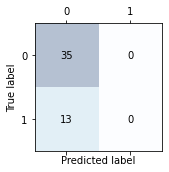

[[35  0]
 [13  0]]
[[35  0]
 [13  0]]


In [428]:
def main(route_name,dep,days_ago,atri,model_file):
    img_time_com=["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
    img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
    #atri = "wave_height" 
    days_ago = days_ago   
#     route_name="kohama_route"
#     dep="kohama_dep"
    nb_classes = 2
    img_size = 64
    file=route_roop(route_name,dep)
    #print(file)
    df_list = make_df(file) 
    img_path,date_list = df_loop(df_list,img_time_com,img_time,atri,days_ago)
    arrlist,err_date,img_paths = img_load(img_path,date_list,img_size)
    print("読み込めなかった総数",len(err_date))
    print(len(df_list))
    df = err_img(df_list,err_date)
    df1 = df[df["Label"] != 0]
    #print(df1)
    print("総数 {}".format(len(df)))
    print("欠航の数 {}".format(len(df1)))
    df2 = df[df["Label"] != 1]
    print("運行の数 {}".format(len(df2)))
    print("Xの数",len(arrlist))
    nplist = np.array(arrlist)
    #print(nplist)
    print("画像数,size縦,size横,RGB",nplist.shape)
    print("行列の総数",nplist.size)
    #print(50000*32*32*3)
    print(len(nplist))
    X_train, X_test, y_train, y_test, z_train, z_test, img_train, img_test = train_data_make(nplist,df,img_paths)
    
    model_filename="../data/img_save_64/"+atri+"_"+route_name+"_"+dep+"_"+str(days_ago)+".h5"
    
    if model_file != "":
        model = load_model("../data/img_save_64/"+model_file)
    else:
        model = Sequential()

        model.add(Conv2D(img_size,3,input_shape=(img_size,img_size,3)))
        model.add(Activation('relu'))
        model.add(Conv2D(img_size,3))
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2)))

        model.add(Conv2D(img_size*2,3))
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2)))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))#1.0

        model.add(Dense(nb_classes, activation='softmax'))

        adam = Adam(lr=1e-4)

        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])



        #エポック数　100
        nb_epoch = 10
        #バッチサイズ　500
        batch_size = 32
        model_filename="../data/img_save_64/"+atri+"_"+route_name+"_"+dep+"_"+str(days_ago)+".h5"
        history = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=nb_epoch, 
                            verbose=1, 
                            validation_data=(X_test,y_test),
                            callbacks=[
                                      ModelCheckpoint(monitor='val_accuracy', 
                                                      mode='max', 
                                                      filepath=model_filename, 
                                                      save_best_only=True)],
                           )


    y_pred = test_acc(model,X_test,z_test)
    y_pred_train = test_acc(model,X_train,z_train)
    
    y_test_re = y_test_make(y_test)
    #print("test_loss: %.3f" % test_loss)
    #print("test_acc: %.3f" % test_acc)
    print('Accuracy : %.3f' % accuracy_score(y_test_re, y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test_re, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y_test_re, y_pred=y_pred))
    print('F1: %.3f' % f1_score(y_true=y_test_re, y_pred=y_pred))

    confmat = confm(route_name,dep,days_ago,atri,img_size,y_pred,y_test)
    print(confmat)

#     path_w = "../data/result_img/"+atri+"/2_2_img_"+route_name+"_"+dep+".txt"
#     with open(path_w, mode='a') as f:
#         f.writelines('\n出発航路'+route_name+' 出発港'+dep+' 日にち '+str(days_ago)+'日前 \n')

#         f.writelines("総数 {}\n".format(len(df)))
#         f.writelines("欠航の数 {}\n".format(len(df1)))
#         f.writelines("運行の数 {}\n".format(len(df2)))
#         f.writelines("画像数,size縦,size横,RGB ({})\n".format(nplist.shape))
#         f.writelines("行列の総数 {}\n".format(nplist.size))

#         f.writelines('Accuracy : %.3f\n' % accuracy_score(y_test_re, y_pred))
#         f.writelines('Precision: %.3f\n' % precision_score(y_true=y_test_re, y_pred=y_pred))
#         f.writelines('Recall: %.3f\n' % recall_score(y_true=y_test_re, y_pred=y_pred))
#         f.writelines('F1: %.3f\n' % f1_score(y_true=y_test_re, y_pred=y_pred))
#         f.writelines(str(confmat)+"\n")
    return y_test,z_test,img_test,y_pred,y_train,z_train,img_train,y_pred_train
        
#for i in range(1,10):
atri = "wind_speed"#"wave_height"
route_name="hateruma_route"
dep="hateruma_dep"
days_ago = 2
model_file = "wind_speed_hateruma_route_hateruma_dep_2.h5"#"wind_speed_hateruma_route_hateruma_dep_1.h5"#"taketomi_route_taketomi_dep_0.h5"#""#"wave_height_hateruma_route_hateruma_dep_1.h5"
y_test,z_test,img_test,y_pred,y_train,z_train,img_train,y_pred_train = main(route_name,dep,days_ago,atri,model_file)
#main(2) 

In [429]:
#print(img_test)
y_test_re = y_test_make(y_test)
for ture, pred, date, path in zip(y_test_re ,y_pred,z_test, img_test):
    print(int(ture), pred, date, path)

0 0 2020-09-13 13:25:00 ../data/now_img_scrape/wind_speed/13:00/2020-09-11 13:00:00.png
0 0 2021-01-10 13:15:00 ../data/now_img_scrape/wind_speed/13:00/2021-01-08 13:00:00.png
0 0 2020-09-15 16:50:00 ../data/now_img_scrape/wind_speed/17:00/2020-09-13 17:00:00.png
1 0 2021-01-17 09:50:00 ../data/now_img_scrape/wind_speed/9:00/2021-01-15 09:00:00.png
0 0 2021-01-06 16:20:00 ../data/now_img_scrape/wind_speed/17:00/2021-01-04 17:00:00.png
0 0 2020-08-28 16:50:00 ../data/now_img_scrape/wind_speed/17:00/2020-08-26 17:00:00.png
1 0 2020-12-03 16:20:00 ../data/now_img_scrape/wind_speed/17:00/2020-12-01 17:00:00.png
0 0 2020-12-07 09:50:00 ../data/now_img_scrape/wind_speed/9:00/2020-12-05 09:00:00.png
0 0 2020-09-10 13:25:00 ../data/now_img_scrape/wind_speed/13:00/2020-09-08 13:00:00.png
0 0 2021-01-11 16:20:00 ../data/now_img_scrape/wind_speed/17:00/2021-01-09 17:00:00.png
1 0 2020-12-30 09:50:00 ../data/now_img_scrape/wind_speed/9:00/2020-12-28 09:00:00.png
1 0 2020-12-09 16:20:00 ../data/now

In [ ]:
y_train_re = y_test_make(y_train)
for ture, pred, date, path in zip(y_train_re ,y_pred_train,z_train, img_train):
    print(int(ture), pred, date, path)

In [212]:
nplist = np.array(arrlist)
#print(nplist)
print("画像数,size縦,size横,RGB",nplist.shape)
print("行列の総数",nplist.size)
#print(50000*32*32*3)
print(len(nplist))
# route_name = "taketomi_route"
# dep = "isigaki_dep"
# days_ago = 1
# file="../data/img_learn_data/"+route_name+"_"+dep+"_"+str(days_ago)+".npy"
# nplist = np.load(file)
#print(nplist)
X_train, X_test, y_train, y_test, z_train, z_test = train_data_make(nplist,df)
y_test

画像数,size縦,size横,RGB (151, 32, 32, 3)
行列の総数 463872
151
151
151
Labels counts in y[0 1]: [82 69]
Labels counts in y_train[0 1]: [65 55]
Labels counts in y_test[0 1]: [17 14]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [198]:
df1 = df[df["Label"] != 0]
print(df1)
print("総数\n{}".format(len(df)))
print("欠航の数\n{}".format(len(df1)))
df2 = df[df["Label"] != 1]
print("運行の数\n{}".format(len(df2)))

      Time  Label        Date            DateTime
2    09:30      1  2020-09-05 2020-09-05 09:30:00
3    16:00      1  2020-09-05 2020-09-05 16:00:00
4    09:30      1  2020-09-06 2020-09-06 09:30:00
5    16:00      1  2020-09-06 2020-09-06 16:00:00
6    09:30      1  2020-09-07 2020-09-07 09:30:00
..     ...    ...         ...                 ...
131  08:30      1  2021-01-18 2021-01-18 08:30:00
132  15:20      1  2021-01-18 2021-01-18 15:20:00
141  08:30      1  2021-01-24 2021-01-24 08:30:00
142  15:20      1  2021-01-24 2021-01-24 15:20:00
150  15:20      1  2021-01-28 2021-01-28 15:20:00

[69 rows x 4 columns]
総数
151
欠航の数
69
運行の数
82


In [191]:
# img_time_com=["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
# img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
# #files = csv_label_path()                              #csvのpathの取得
# #df_list = make_df(files[0])                                   #csvからdfの作成
# atri = "wave_height"                                  #波の高さの画像のみ取得
# days_ago = 9                                          #何日前の日付の画像を使用するか
# route_name_dic = {
#         "taketomi_route" : ["isigaki_dep","taketomi_dep"],
#         "kurosima_route" : ["isigaki_dep","kurosima_dep"],
#         "kohama_route" : ["isigaki_dep","kohama_dep"],
#         "iriomote_uehara_route" : ["isigaki_dep","uehara_dep"],
#         "hatoma_route" : ["isigaki_dep","hatoma_dep"],
#         "iriomote_ohara_route" : ["isigaki_dep","ohara_dep"],
#         "hateruma_route" : ["isigaki_dep","hateruma_dep"]
#     }
# #files =[]
# count=0
# for route_name,deps in route_name_dic.items():    #航路分回る(7回)
#     #print(key,value)
#     for dep in deps:    #出発港分回る(2回)
#         df_list = make_df(files[count])   
#         img_path,date_list = df_loop(df_list,img_time_com,img_time,atri,days_ago)     #画像のpath取得
#         arrlist,err_date = img_load(img_path,date_list)                          #画像の行列の取得
#         data_save(arrlist,route_name,dep,days_ago)
#         count=+1
#         #break    #まずは竹富航路までテスト##################


In [265]:
# print(arrlist)

In [322]:
def err_img(df_list,err_date):
    """
    df_list = make_df(files[0])
    """
    df = df_list[0]
    for i in range(1,len(df_list)):#0を1に変更
        df = pd.concat([df, df_list[i]], axis=0)
    #print(df)

    for i in err_date:
        #print(i)
        df = df[df["DateTime"] != i]
    df = df.reset_index(drop=True)
    #print(df)
    return df

df = err_img(df_list,err_date)

In [11]:
print(len(X))
print(len(y))

NameError: name 'X' is not defined

In [266]:
# df1 = df[df["Label"] != 0]
# print(df1)
# print("総数\n{}".format(len(df)))
# print("欠航の数\n{}".format(len(df1)))
# df2 = df[df["Label"] != 1]
# print("運行の数\n{}".format(len(df2)))

In [60]:
def data_save(arrlist,route_name,dep,days_ago):
    nplist = np.array(arrlist)
    filename = "../data/img_learn_data/"+route_name+"_"+dep+"_"+str(days_ago)
    np.save(filename, nplist)
    print(">> data/route/windy_imgから" + str(len(nplist)) + "個のファイル読み込み成功")
    print(">> "+filename+"にファイル保存成功")

In [14]:
#print(arrlist)
#nplist
nplist = np.array(arrlist)
print(type(nplist))
print("画像数,size縦,size横,RGB",nplist.shape)
print("行列の総数",nplist.size)
#print(50000*32*32*3)
print(len(nplist))

<class 'numpy.ndarray'>
画像数,size縦,size横,RGB (919, 32, 32, 3)
行列の総数 2823168
919


In [354]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split
# data = 
# np.load(
#     file="MLP_params.npy",  # npyかnpz拡張子のファイルを指定
# )
def train_data_make(nplist,df,img_paths):
    """
    nplist:データ
    y: df = err_img(df_list)
    """
    X = nplist

    y = df['Label'].values
    y = np.array(y).reshape(-1, 1).tolist()
    y_y = []

    for i in y:
        for l in i:
           y_y.append(l) 
        
    y = pd.Series(y_y)
    z = df['DateTime']
    #print(type(y))
    #print(len(y))
    #print(len(X))
    X_train, X_test, y_train, y_test, z_train, z_test, img_train, img_test = train_test_split(
        X, y, z, img_paths, test_size=0.2, random_state=1, stratify=y)
    print('Labels counts in y[0 1]:', np.bincount(y))
    print('Labels counts in y_train[0 1]:', np.bincount(y_train))
    print('Labels counts in y_test[0 1]:', np.bincount(y_test))

    nb_classes = 2

    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    
    return X_train, X_test, y_train, y_test, z_train, z_test, img_train, img_test
# 919
# 919
# Labels counts in y[0 1]: [898  21]
# Labels counts in y_train[0 1]: [718  17]
# Labels counts in y_test[0 1]: [180   4]
route_name = "taketomi_route"
dep = "isigaki_dep"
days_ago = 1
file="../data/img_learn_data/"+route_name+"_"+dep+"_"+str(days_ago)+".npy"
nplist = np.load(file)
#print(nplist)
X_train, X_test, y_train, y_test, z_train, z_test, img_train, img_test = train_data_make(nplist,df,img_paths)

NameError: name 'img_paths' is not defined

In [16]:
print(y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [195]:

# y = df['Label'].values
# y = np.array(y).reshape(-1, 1).tolist()
# print(type(y))
# #print(type(y))
# y_test = y[172:262]
# y_train = np.concatenate([y[0:172], y[262:]])

# print("y_train\n{}\ny_train {}".format(y_train,len(y_train)))
# print("y_test\n{}\ny_test {}".format(y_test,len(y_test)))
# #print(y_train)
# print("y_test 1\n{}\ny_test 0\n{}".format(y_test.count(1),y_test.count(0)))



In [196]:
# nb_classes = 2

# y_train = np_utils.to_categorical(y_train, nb_classes)
# y_test = np_utils.to_categorical(y_test, nb_classes)
# print(y_train)
# print(y_test.shape)

In [197]:
# X = nplist
# print(type(X))
# X_test = X[172:262]
# X_train = np.concatenate([X[0:172], X[262:]])

# print("X_train\n{}".format(len(X_train)))
# print("X_test\n{}".format(len(X_test)))
# #print(X_train)

In [288]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard
# モデルの定義
model = Sequential()

model.add(Conv2D(32,3,input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))#1.0

model.add(Dense(nb_classes, activation='softmax'))

adam = Adam(lr=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_40 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_41 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_42 (Activation)   (None, 12, 12, 64)       

In [297]:
#エポック数　100
nb_epoch = 10

#バッチサイズ　500
batch_size = 500

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 0s 210ms/step - loss: 0.6986 - accuracy: 0.5041 - val_loss: 0.6764 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6874 - accuracy: 0.5372 - val_loss: 0.6655 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 24ms/step - loss: 0.6770 - accuracy: 0.5785 - val_loss: 0.6549 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 25ms/step - loss: 0.6547 - accuracy: 0.6198 - val_loss: 0.6434 - val_accuracy: 0.7143
Epoch 5/10
1/1 [==============================] - 0s 27ms/step - loss: 0.6496 - accuracy: 0.6364 - val_loss: 0.6316 - val_accuracy: 0.7857
Epoch 6/10
1/1 [==============================] - 0s 31ms/step - loss: 0.6218 - accuracy: 0.7355 - val_loss: 0.6200 - val_accuracy: 0.7857
Epoch 7/10
1/1 [==============================] - 0s 24ms/step - loss: 0.6262 - accuracy: 0.7438 - val_loss: 0.6086 - val_accuracy: 0.7857
Epoch 8/10
1/1 [==========

In [306]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def test_acc(model,X_test,z_test):
    y_pred_test=model.predict(X_test)
    y_pred = y_pred_test.argmax(axis=1)
#     print(y_pred)
#     print(y_pred_test)
#     print(y_test)
    z_test = pd.DataFrame(z_test)
    cnt = 0
    y_test_re = y_test_make(y_test)
#     for index, row in z_test.iterrows():

#         #print(y_pred[cnt],y_test[cnt],row[0])#

#     #     for i in range(len(y_pred)):
#     #         #print(cnt)
#     #         print(y_pred[cnt],y_test[cnt])
#     #         break
#         cnt +=1

#     for i in range(len(y_pred)):
#         print(y_pred[i],y_test_re[i])
    #test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    #print('Accuracy : %.3f\n' % accuracy_score(y_test_re, y_pred))
    
    return y_pred

def y_test_make(y_test):
    y_test_re = y_test.reshape(-1)[1::2]
    return y_test_re

y_pred = test_acc(model,X_test,z_test)
y_test_re = y_test_make(y_test)
#print("test_loss: %.3f" % test_loss)
#print("test_acc: %.3f" % test_acc)
print('Accuracy : %.3f' % accuracy_score(y_test_re, y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test_re, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test_re, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test_re, y_pred=y_pred))

#[1. 0.]運行
#[0. 1.]欠航
# y_pred_test = [0 if i < 0.5 else 1 for i in y_pred_test]   #二値表記に直している
# print(accuracy_score(y_pred_test, y_pred))

Accuracy : 0.794
Precision: 0.846
Recall: 0.688
F1: 0.759


In [275]:
print(y_test, y_pred)

[0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [194]:
df.loc[11,:]
print(type(y_pred))

<class 'numpy.ndarray'>


In [284]:
y_testx=y_test.reshape(-1)[1::2]
print(y_testx)

[0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]


In [384]:
#混同行列
from sklearn.metrics import confusion_matrix


def confm(route_name,dep,days_ago,atri,img_size,y_pred,y_test):
    #y_test=y_test.reshape(-1)[1::2]
    y_test_re = y_test_make(y_test)
    confmat = confusion_matrix(y_true=y_test_re, y_pred=y_pred)
    

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.savefig('../data/images_conf_img_'+str(img_size)+'/'+atri+'/'+route_name+'_'+dep+'_'+str(days_ago)+'.png', dpi=300)
    plt.show()
    print(confmat)
    
    return confmat
confmat = confm(route_name,dep,days_ago,atri,y_pred,y_test)
print(confmat)

TypeError: confm() missing 1 required positional argument: 'y_test'

In [206]:
import pandas as pd

#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 100)
#現在の最大表示行数の出力
pd.get_option("display.max_rows")

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 100)
z_train

14    2020-09-12 16:00:00
72    2020-12-16 08:30:00
73    2020-12-16 15:20:00
105   2021-01-03 08:30:00
29    2020-09-20 16:00:00
              ...        
61    2020-12-10 15:20:00
40    2020-09-26 16:00:00
90    2020-12-26 15:20:00
8     2020-09-08 09:30:00
89    2020-12-26 08:30:00
Name: DateTime, Length: 120, dtype: datetime64[ns]

In [280]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))


In [281]:
optimizers ="Adadelta"
results = {}
epochs = 20
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
history= model.fit(X_train, y_train, validation_split=0.2, epochs=epochs )
#results
model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mnist_mlp_weights.h5');

Epoch 1/20
4/4 [==============================] - 0s 77ms/step - loss: 0.7022 - accuracy: 0.4907 - val_loss: 0.7062 - val_accuracy: 0.4074
Epoch 2/20
4/4 [==============================] - 0s 46ms/step - loss: 0.7100 - accuracy: 0.4537 - val_loss: 0.7058 - val_accuracy: 0.4074
Epoch 3/20
4/4 [==============================] - 0s 55ms/step - loss: 0.7135 - accuracy: 0.4444 - val_loss: 0.7053 - val_accuracy: 0.4074
Epoch 4/20
4/4 [==============================] - 0s 53ms/step - loss: 0.6893 - accuracy: 0.5463 - val_loss: 0.7049 - val_accuracy: 0.4074
Epoch 5/20
4/4 [==============================] - 0s 46ms/step - loss: 0.6977 - accuracy: 0.4444 - val_loss: 0.7045 - val_accuracy: 0.4074
Epoch 6/20
4/4 [==============================] - 0s 47ms/step - loss: 0.6919 - accuracy: 0.5556 - val_loss: 0.7041 - val_accuracy: 0.4074
Epoch 7/20
4/4 [==============================] - 0s 44ms/step - loss: 0.7109 - accuracy: 0.4815 - val_loss: 0.7038 - val_accuracy: 0.4074
Epoch 8/20
4/4 [===========

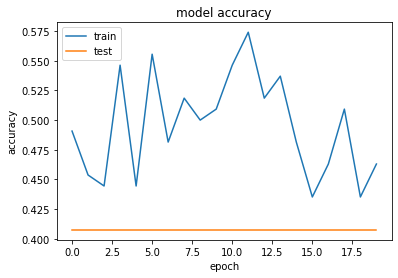

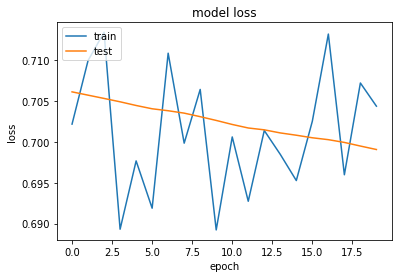

In [282]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
def main():
    files = csv_label_path()                              #csvのpathの取得
    df_list = make_df(files[0])                                   #csvからdfの作成
    atri = "wave_height"                                  #波の高さの画像のみ取得
    img_time_com=["08:00:00","10:00:00","12:00:00","14:00:00","16:00:00"]
    img_time = ["07:00:00","09:00:00","11:00:00","13:00:00","15:00:00","17:00:00"]
    days_ago=1
    #img_path = df_loop(df,img_time_com,img_time,atri)     #画像のpath取得
    img_path,date_list = df_loop(df_list,img_time_com,img_time,atri,days_ago)     #画像のpath取得
    arrlist,err_date = img_load(img_path,date_list)                          #画像の行列の取得
    
    df = err_img(df_list)
    
    file="../data/img_learn_data/"+route_name+"_"+dep+"_"+str(days_ago)+".npy"
    nplist = np.load(file)
    
    X_train, X_test, y_train, y_test = train_data_make(nplist,df)
    df1 = df[df["Label"] != 0]
    print("総数\n{}".format(len(df)))
    print("欠航の数\n{}".format(len(df1)))
    df2 = df[df["Label"] != 1]
    print("運行の数\n{}".format(len(df2)))
    nplist = np.array(arrlist)

    
    print(">> data/route/windy_imgから" + str(len(nplist)) + "個のファイル読み込み成功")
    #print(type(nplist))
    print("画像数,size縦,size横,RGB",nplist.shape)
    print("行列の総数",nplist.size)
    #print(50000*32*32*3)
    print(len(nplist))

    #img_path, a = df_loop(df_list,img_time_com,img_time,atri,days_ago)
#     nplist = np.array(arrlist)
#     filename = "wave_heghit"
#     np.save(filename, nplist)
    #print(">> " + dirname + "から" + str(num) + "個のファイル読み込み成功")
main()

KeyboardInterrupt: 

In [50]:
if __name__ == '__main__':
    main()

isigaki_dep
../data/route/taketomi_route/isigaki_dep/*.csv
['../data/route/taketomi_route/isigaki_dep/2020-08-02.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-03.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-04.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-05.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-06.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-07.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-08.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-09.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-10.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-11.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-12.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-13.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-14.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-15.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-16.csv', '../data/route/taketomi_route/isigaki_dep/2020-08-17.cs

<class 'str'>
2020-08-02 07:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 07:00:00.png
True
<class 'str'>
2020-08-02 08:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png
True
<class 'str'>
2020-08-02 09:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 09:00:00.png
True
<class 'str'>
2020-08-02 10:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png
True
<class 'str'>
2020-08-02 11:50:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 11:00:00.png
True
<class 'str'>
2020-08-02 13:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 13:00:00.png
True
<class 'str'>
2020-08-02 14:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png
True
<class 'str'>
2020-08-02 15:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 15:00:00.png
True
<class 'str'>
2020-08-02 16:20:00
../data/windy_img/2020-08-02/wave_height/2020-08-02 17:00:00.png
<class 'str'>
2020-08-02 17:20:00
../data/windy_img/2020-08-02/wave_h

<class 'str'>
2020-09-04 08:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 09:00:00.png
True
<class 'str'>
2020-09-04 09:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 09:00:00.png
True
<class 'str'>
2020-09-04 10:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 11:00:00.png
True
<class 'str'>
2020-09-04 11:50:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 11:00:00.png
True
<class 'str'>
2020-09-04 13:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 13:00:00.png
True
<class 'str'>
2020-09-04 14:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 15:00:00.png
True
<class 'str'>
2020-09-04 15:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 15:00:00.png
True
<class 'str'>
2020-09-04 16:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 17:00:00.png
<class 'str'>
2020-09-04 17:20:00
../data/windy_img/2020-09-04/wave_height/2020-09-04 17:00:00.png
<class 'str'>
2020-09-04 18:20:00
../data/windy_img/2020-09-04/wave_height

True
<class 'str'>
2020-09-28 13:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 13:00:00.png
True
<class 'str'>
2020-09-28 14:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 15:00:00.png
True
<class 'str'>
2020-09-28 15:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 15:00:00.png
True
<class 'str'>
2020-09-28 16:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-28 17:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-28 18:20:00
../data/windy_img/2020-09-28/wave_height/2020-09-28 17:00:00.png
<class 'str'>
2020-09-29 07:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 07:00:00.png
True
<class 'str'>
2020-09-29 08:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 09:00:00.png
True
<class 'str'>
2020-09-29 09:50:00
../data/windy_img/2020-09-29/wave_height/2020-09-29 09:00:00.png
True
<class 'str'>
2020-09-29 10:50:00
../data/windy_img/2020-09-29/wave_height

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-09-22/wave_height/2020-09-22 15:00:00.png'
FileNotFoundErro

FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 07:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 09:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 11:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 13:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundError: [Errno 2] No such file or directory: '../data/windy_img/2020-11-09/wave_height/2020-11-09 15:00:00.png'
FileNotFoundErro